# **Imaging Esophageal Cancer Status Prediction**

## Dataset Overview

Name: Esophageal Endoscopy

-> This dataset consists of endoscopy images categorized into two classes:

    - Esophagus (Positive/Abnormal): Images showing signs of disease or specific esophageal features.
    - No-Esophagus (Negative/Normal): Images of healthy tissue or other regions.

## Challenge:

The dataset is highly imbalanced (~16% positive vs. 84% negative). If trained normally, the model will bias heavily towards the majority class ("No-Esophagus") to minimize loss, resulting in high accuracy but very low sensitivity (Recall) for detecting the actual disease.

## The Solution Implemented Below:

    - Oversampling: We create a data pipeline that artificially repeats images from the minority class so the model sees a 50/50 split during training.
    - Resolution Upgrade: Increased from 64x64 to 224x224 to capture tissue texture.
    - Transfer Learning: Using EfficientNetB0 (pretrained on ImageNet) to leverage learned feature extraction capabilities.

### Cell 01: Importing libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tqdm.keras
from tqdm.keras import TqdmCallback

print("All libraries have been imported successfully!")

All libraries have been imported!


### Cell 02:



In [2]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
IMG_SIZE = 224  # Increased from 64 for better feature extraction
BATCH_SIZE = 32
DATA_DIR = r'E:\NLP\Assignment\1&2\Esophageal_Cancer_Project\Data\Imaging\Endoscopy-esophagus'

print(f"TensorFlow Version: {tf.__version__}")
print("Setup Complete.")

TensorFlow Version: 2.20.0
Setup Complete.


Scanning directory...
Class 'esophagus': found 1689 images
Class 'no-esophagus': found 8973 images


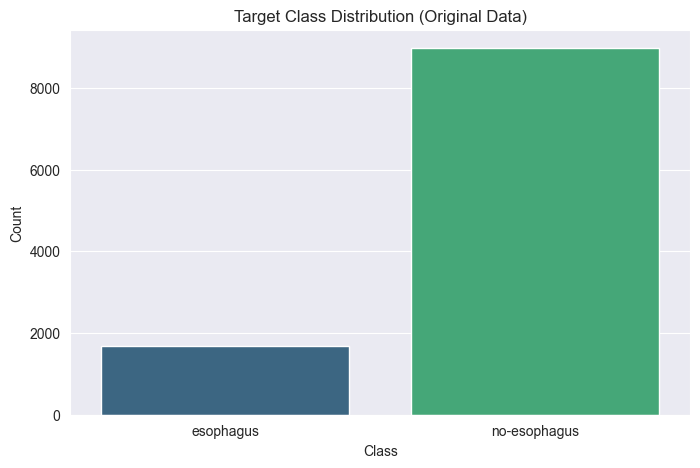


Splits created:
Training: 8529 images
Validation: 1066 images
Testing: 1067 images


In [4]:
# Cell 2: Data Loading & Class Distribution Visualization

# 1. Gather all file paths manually to handle balancing explicitly
file_paths = []
labels = []
class_names = sorted(os.listdir(DATA_DIR))

print("Scanning directory...")
for label, class_name in enumerate(class_names):
    class_dir = os.path.join(DATA_DIR, class_name)
    if os.path.isdir(class_dir):
        files = os.listdir(class_dir)
        print(f"Class '{class_name}': found {len(files)} images")
        for f in files:
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_paths.append(os.path.join(class_dir, f))
                labels.append(label)

# Create a DataFrame
df = pd.DataFrame({'path': file_paths, 'label': labels, 'class_name': [class_names[l] for l in labels]})

# 2. Visualize Target Class Distribution
plt.figure(figsize=(8, 5))

# --- FIX IS HERE ---
# Added hue='class_name' and legend=False
sns.countplot(data=df, x='class_name', hue='class_name', legend=False, palette='viridis')

plt.title('Target Class Distribution (Original Data)')
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

# 3. Stratified Split (Train/Val/Test)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'], random_state=42)

print(f"\nSplits created:")
print(f"Training: {len(train_df)} images")
print(f"Validation: {len(val_df)} images")
print(f"Testing: {len(test_df)} images")

In [11]:
# Function to load and preprocess images
def load_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32)
    return img, label

# Create Tensorflow Datasets
def create_dataset(dataframe, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((dataframe['path'].values, dataframe['label'].values))
    ds = ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    return ds

# --- BALANCING LOGIC (UPDATED) ---
# We separate the training data by class
train_0 = train_df[train_df['label'] == 0]
train_1 = train_df[train_df['label'] == 1]

# Create two separate datasets AND REPEAT THEM
# .repeat() makes them infinite, so sample_from_datasets never runs dry
ds_0 = create_dataset(train_0, shuffle=True).repeat()
ds_1 = create_dataset(train_1, shuffle=True).repeat()

# We define specific sampling weights to ensure 50/50 split in batches
balanced_ds = tf.data.Dataset.sample_from_datasets([ds_0, ds_1], weights=[0.5, 0.5])

# Finalize Pipeline with Batching and Prefetching
# Note: Since balanced_ds is now infinite, 'steps_per_epoch' in model.fit will determine when an epoch ends.
train_dataset = balanced_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation and Test should NOT repeat (we want to evaluate them exactly once)
val_dataset = create_dataset(val_df).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = create_dataset(test_df).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Balanced Data Pipeline Created Successfully (Infinite Generator).")

Balanced Data Pipeline Created Successfully (Infinite Generator).


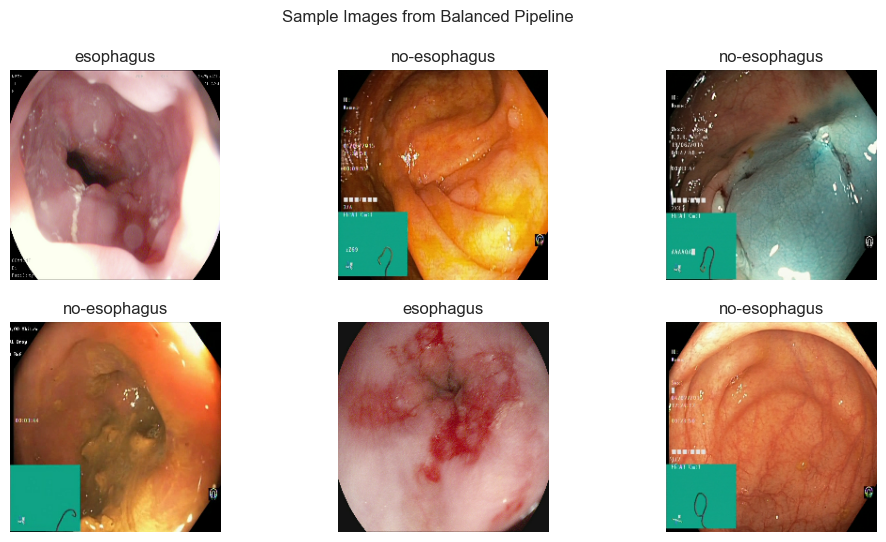

In [12]:
# Show first 6 images from the Balanced Training Set
plt.figure(figsize=(12, 6))
# Take one batch
for images, labels_batch in train_dataset.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        # Rescale back to 0-255 for display if needed, or just cast to uint8
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
plt.suptitle("Sample Images from Balanced Pipeline")
plt.show()

In [13]:
def build_model():
    # 1. Base Model: EfficientNetB0 (Pretrained on ImageNet)
    # include_top=False means we cut off the final classification layer
    base_model = applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze the base model initially
    base_model.trainable = False

    # 2. Augmentation Layers (Built into model)
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.2),
    ])

    # 3. Build Model Structure
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)

    # EfficientNet has built-in normalization, but we ensure inputs are passed correctly
    x = base_model(x, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x) # Dropout to prevent overfitting
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Binary output (1 neuron) because we have 2 classes
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs, name="EfficientNet_Endo_Classifier")

    # 4. Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

model = build_model()
print("Model Built.")

Model Built.


In [14]:
# Create a dataframe for the summary to satisfy requirement
summary_data = []
for layer in model.layers:
    # Safely get output shape
    try:
        # Standard layers usually have this
        out_shape = layer.output_shape
    except AttributeError:
        # InputLayers or some TF versions might need this fallback
        try:
            out_shape = layer.input_shape
        except AttributeError:
            out_shape = "N/A"

    summary_data.append({
        "Layer Name": layer.name,
        "Type": layer.__class__.__name__,
        "Output Shape": out_shape,
        "Trainable": layer.trainable
    })

summary_df = pd.DataFrame(summary_data)
print("Model Architecture Summary:")
display(summary_df)

# Standard Keras Summary
model.summary()

Model Architecture Summary:


,Layer Name,Type,Output Shape,Trainable
0,input_layer_4,InputLayer,N/A,True
1,sequential_1,Sequential,"(None, 224, 224, 3)",True
2,efficientnetb0,Functional,"(None, 7, 7, 1280)",False
3,global_average_pooling2d_1,GlobalAveragePooling2D,N/A,True
4,batch_normalization_1,BatchNormalization,N/A,True
5,dropout_2,Dropout,N/A,True
6,dense_2,Dense,N/A,True
7,dropout_3,Dropout,N/A,True
8,dense_3,Dense,N/A,True


Model: "EfficientNet_Endo_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,218,788 (16.09 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [15]:
tqdm_callback = TqdmCallback(verbose=1)

# Callbacks for rich training control
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=0
    )
]

# Steps per epoch calculation (since we are generating data infinitely with sample_from_datasets)
# We set steps to cover the size of the original majority class to ensure full coverage
steps_per_epoch = len(train_df) // BATCH_SIZE

print("Starting Training...")
history = model.fit(
    train_dataset,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=0
)

Starting Training...
Epoch 1/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 245s 881ms/step - accuracy: 0.9723 - auc: 0.9968 - loss: 0.0684 - val_accuracy: 0.9869 - val_auc: 0.9996 - val_loss: 0.0409 - learning_rate: 0.0010
Epoch 2/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 243s 913ms/step - accuracy: 0.9873 - auc: 0.9984 - loss: 0.0379 - val_accuracy: 0.9859 - val_auc: 0.9982 - val_loss: 0.0476 - learning_rate: 0.0010
Epoch 3/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 237s 893ms/step - accuracy: 0.9886 - auc: 0.9991 - loss: 0.0285 - val_accuracy: 0.9925 - val_auc: 0.9994 - val_loss: 0.0223 - learning_rate: 0.0010
Epoch 4/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 239s 899ms/step - accuracy: 0.9892 - auc: 0.9989 - loss: 0.0308 - val_accuracy: 0.9925 - val_auc: 0.9994 - val_loss: 0.0250 - learning_rate: 0.0010
Epoch 5/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 241s 905ms/step - accuracy: 0.9914 - auc: 0.9991 - loss: 0.0239 - val_accuracy: 0.9962 - val_auc: 0.9994 - val_loss: 0.0108 - learning_rate: 0.0010
Epoch 6/15
266/266 ━━━━━━━━━━━━━━━━━━━━

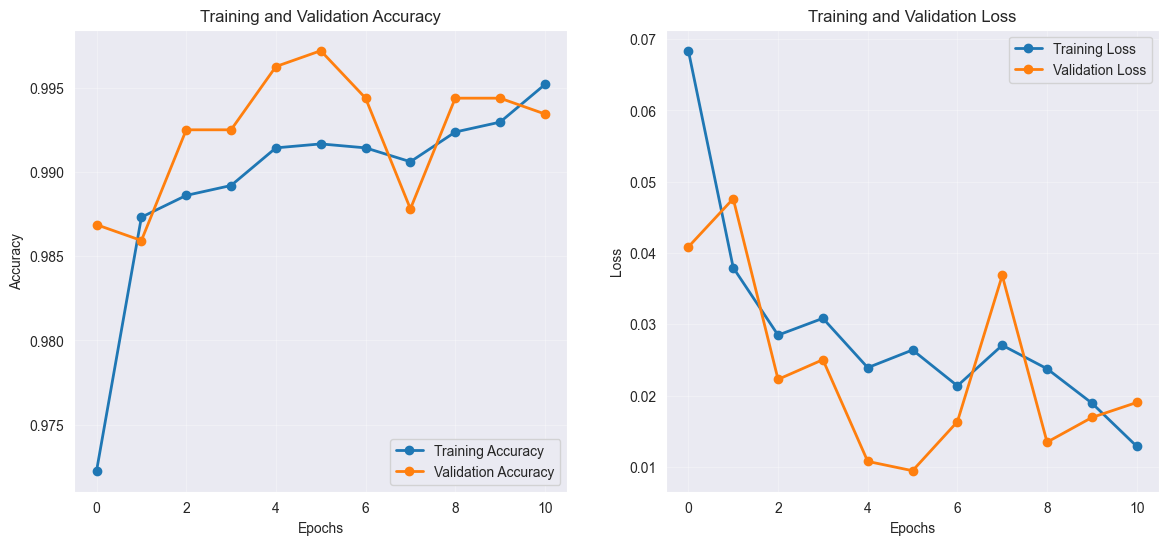

In [16]:
# Extract history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2, marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2, marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth=2, marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2, marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

plt.show()

Running Final Predictions on Test Set...
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 718ms/step


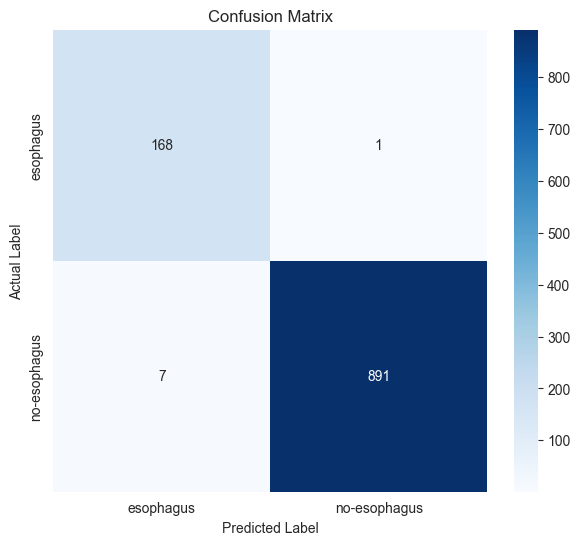


--- Classification Report ---
              precision    recall  f1-score   support

   esophagus       0.96      0.99      0.98       169
no-esophagus       1.00      0.99      1.00       898

    accuracy                           0.99      1067
   macro avg       0.98      0.99      0.99      1067
weighted avg       0.99      0.99      0.99      1067



In [17]:
print("Running Final Predictions on Test Set...")
# Predict
# Note: Test dataset is NOT balanced, so it reflects real world performance
predictions = model.predict(test_dataset)
y_pred_probs = predictions.flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Extract true labels from test dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

In [18]:
# Calculate specific metrics
train_loss, train_acc, train_auc = model.evaluate(train_dataset, steps=50, verbose=0) # sample steps
val_loss, val_acc, val_auc = model.evaluate(val_dataset, verbose=0)
test_loss, test_acc, test_auc = model.evaluate(test_dataset, verbose=0)

print(f"{'Metric':<20} {'Score':<10}")
print("-" * 30)
print(f"{'Training Accuracy':<20} {train_acc*100:.2f}%")
print(f"{'Validation Accuracy':<20} {val_acc*100:.2f}%")
print(f"{'Testing Accuracy':<20} {test_acc*100:.2f}%")

Metric               Score     
------------------------------
Training Accuracy    99.62%
Validation Accuracy  99.72%
Testing Accuracy     99.25%


In [20]:
# Identify indices
correct_indices = np.where(y_pred == y_true)[0]
incorrect_indices = np.where(y_pred != y_true)[0]

# Prepare data for table
prediction_review = []

# Get 10 Correct
# We use min() to handle cases where there might be fewer than 10 correct
limit_correct = min(10, len(correct_indices))
for i in correct_indices[:limit_correct]:
    prediction_review.append({
        "Status": "Correct",
        "Actual": class_names[y_true[i]],
        "Predicted": class_names[y_pred[i]],
        "Confidence": f"{y_pred_probs[i]:.4f}" if y_pred[i] == 1 else f"{1-y_pred_probs[i]:.4f}"
    })

# Get 5 Incorrect (if available)
if len(incorrect_indices) > 0:
    limit_incorrect = min(5, len(incorrect_indices))
    for i in incorrect_indices[:limit_incorrect]:
        prediction_review.append({
            "Status": "Incorrect",
            "Actual": class_names[y_true[i]],
            "Predicted": class_names[y_pred[i]],
            "Confidence": f"{y_pred_probs[i]:.4f}" if y_pred[i] == 1 else f"{1-y_pred_probs[i]:.4f}"
        })
else:
    prediction_review.append({"Status": "No Incorrect Predictions Found", "Actual": "-", "Predicted": "-", "Confidence": "-"})

# Create DataFrame
review_df = pd.DataFrame(prediction_review)

# Define coloring function
def color_status(val):
    if val == 'Correct':
        color = 'green'
    elif val == 'Incorrect':
        color = 'red'
    else:
        color = 'black'
    return f'color: {color}; font-weight: bold'

print("Prediction Analysis (Sample):")

# UPDATED LINE: Use .map() instead of .applymap()
display(review_df.style.map(color_status, subset=['Status']))

Prediction Analysis (Sample):


,Status,Actual,Predicted,Confidence
0,Correct,no-esophagus,no-esophagus,1.0000
1,Correct,no-esophagus,no-esophagus,1.0000
2,Correct,no-esophagus,no-esophagus,1.0000
3,Correct,no-esophagus,no-esophagus,0.9978
4,Correct,esophagus,esophagus,0.9989
5,Correct,no-esophagus,no-esophagus,1.0000
6,Correct,no-esophagus,no-esophagus,1.0000
7,Correct,no-esophagus,no-esophagus,1.0000
8,Correct,esophagus,esophagus,1.0000
9,Correct,no-esophagus,no-esophagus,1.0000


In [22]:
# 1. Configuration - Using Absolute Paths
# We use r'' (raw strings) to handle Windows backslashes correctly
MODELS_DIR = r"E:\NLP\Assignment\1&2\Esophageal_Cancer_Project\Models"
REPORTS_DIR = r"E:\NLP\Assignment\1&2\Esophageal_Cancer_Project\Reports"

# Ensure directories exist (just in case)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

# Define Filenames
# Assuming EfficientNetB0 was the model architecture used
MODEL_ARCH = "EfficientNetB0"
model_filename = f"Imaging_Model_{MODEL_ARCH}.keras"
report_filename = f"Imaging_Report_{MODEL_ARCH}.txt"

# Full Paths
model_save_path = os.path.join(MODELS_DIR, model_filename)
report_save_path = os.path.join(REPORTS_DIR, report_filename)

# 2. Save the Model
print(f"Saving model to: {model_save_path}...")
model.save(model_save_path)
print("✅ Model saved successfully.")

# 3. Generate Predictions for the Report
print("Generating predictions for report...")
predictions = model.predict(test_dataset, verbose=0)
y_pred_probs = predictions.flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Get true labels from test dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Calculate Metrics
test_loss, test_acc, test_auc = model.evaluate(test_dataset, verbose=0)
class_report = classification_report(y_true, y_pred, target_names=class_names)
conf_matrix = confusion_matrix(y_true, y_pred)

# 4. Construct Report Content
report_content = f"""Imaging Model Evaluation Report
=========================================
Model Name:      {model_filename}
Architecture:    {MODEL_ARCH}
Image Size:      {IMG_SIZE}x{IMG_SIZE}
=========================================

Overall Metrics:
----------------
Test Accuracy : {test_acc*100:.2f}%
Test AUC      : {test_auc:.4f}
Test Loss     : {test_loss:.4f}

Classification Report:
----------------------
{class_report}

Confusion Matrix:
-----------------
{conf_matrix}
"""

# 5. Save Report to File
print(f"Saving report to: {report_save_path}...")
with open(report_save_path, "w") as f:
    f.write(report_content)

print("✅ Report saved successfully.")
print("\n--- Report Preview ---")
print(report_content)

Saving model to: E:\NLP\Assignment\1&2\Esophageal_Cancer_Project\Models\Imaging_Model_EfficientNetB0.keras...
✅ Model saved successfully.
Generating predictions for report...
Saving report to: E:\NLP\Assignment\1&2\Esophageal_Cancer_Project\Reports\Imaging_Report_EfficientNetB0.txt...
✅ Report saved successfully.

--- Report Preview ---
Imaging Model Evaluation Report
Model Name:      Imaging_Model_EfficientNetB0.keras
Architecture:    EfficientNetB0
Image Size:      224x224

Overall Metrics:
----------------
Test Accuracy : 99.25%
Test AUC      : 0.9985
Test Loss     : 0.0339

Classification Report:
----------------------
              precision    recall  f1-score   support

   esophagus       0.96      0.99      0.98       169
no-esophagus       1.00      0.99      1.00       898

    accuracy                           0.99      1067
   macro avg       0.98      0.99      0.99      1067
weighted avg       0.99      0.99      0.99      1067


Confusion Matrix:
-----------------
[[168